In [ ]:
import pandas as pd
import numpy as np
import os

# Load cumulative label file
labels = pd.read_csv("/content/all_features.csv")

# Example labels.csv columns: kepid, disposition
# disposition could be "CONFIRMED", "FALSE POSITIVE", etc.
print("📝 Column Names:")
print(labels.columns.tolist())
print("\nTotal Columns:", len(labels.columns))

# Display first 10 values for each column
print("\n🔹 First 10 values for each column:\n")
for col in labels.columns:
    print(f"--- {col} ---")
    print(labels[col].head(10).to_list())  # convert to list for cleaner display
    print()

📝 Column Names:
['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

Total Columns: 49

🔹 First 10 values for each column:

--- kepid ---
[3541800, 3115833, 4673628, 4055092, 3440118, 3441340, 4752451, 3554819, 5097470, 3757588]

--- kepoi_name ---
['K00491.01

In [ ]:
import pandas as pd

# Load the original metadata file
file_path = "/content/all_features.csv"
df = pd.read_csv(file_path)

# ✅ Columns we want to keep
columns_to_keep = [
    'kepid',              # Unique identifier
    'koi_disposition',    # Planet label (CONFIRMED / FALSE POSITIVE)
    'koi_period',         # Transit period
    'koi_depth',          # Transit depth
    'koi_prad',           # Planet radius (if available)
    'koi_teq',            # Equilibrium temperature (optional)
    'koi_steff',          # Stellar effective temperature
    'koi_srad',           # Stellar radius
    'koi_model_snr'       # Signal-to-noise ratio
]

# Filter the DataFrame to keep only these columns
clean_df = df[columns_to_keep].copy()

# Optional: drop rows with missing critical values (like kepid or disposition)
clean_df.dropna(subset=['kepid', 'koi_disposition'], inplace=True)

# Save to a new CSV file
output_path = "/content/clean_labels.csv"
clean_df.to_csv(output_path, index=False)

print(f"✅ Cleaned file saved at: {output_path}")
print("📝 Columns in clean file:", clean_df.columns.tolist())
print("\n📊 Preview:")
print(clean_df.head(10))


✅ Cleaned file saved at: /content/clean_labels.csv
📝 Columns in clean file: ['kepid', 'koi_disposition', 'koi_period', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_steff', 'koi_srad', 'koi_model_snr']

📊 Preview:
     kepid koi_disposition  koi_period  koi_depth  koi_prad  koi_teq  \
0  3541800  FALSE POSITIVE    4.662291      345.4     24.12   1166.0   
1  3115833       CANDIDATE   10.181584     5741.1      7.73    812.0   
2  4673628       CONFIRMED    3.951383      405.7     23.51   1083.0   
3  4055092  FALSE POSITIVE   76.453158     9662.2     22.89    291.0   
4  3440118       CONFIRMED   19.577833      432.6      1.96    621.0   
5  3441340  FALSE POSITIVE    0.806277       70.8      0.89   2046.0   
6  4752451  FALSE POSITIVE    6.414965      201.2     25.79   1153.0   
7  3554819  FALSE POSITIVE   43.227931        NaN       NaN      NaN   
8  5097470  FALSE POSITIVE    1.288058       92.6      1.08   1736.0   
9  3757588  FALSE POSITIVE   24.090021     6782.2      9.39    551.0   

In [ ]:
import pandas as pd
import numpy as np

# Constants
G = 6.67430e-11  # gravitational constant (m^3 kg^-1 s^-2)
M_sun = 1.98847e30  # solar mass in kg
R_sun = 6.957e8     # solar radius in m
AU = 1.495978707e11 # 1 AU in m
SECONDS_PER_DAY = 86400

# Load data
df = pd.read_csv("/content/clean_labels.csv")

# Helper: estimate stellar mass using logg and radius (if available)
def estimate_stellar_mass(logg, r_star_rsun):
    """Estimate stellar mass using surface gravity and radius."""
    if np.isnan(logg) or np.isnan(r_star_rsun):
        return 1.0 * M_sun  # assume solar mass
    g_star = 10**logg      # in cm/s²
    g_star_mks = g_star / 100  # convert to m/s²
    r_star_m = r_star_rsun * R_sun
    m_star = g_star_mks * r_star_m**2 / G
    return m_star

# Orbital distance (AU)
def compute_orbital_distance(period_days, m_star):
    if np.isnan(period_days):
        return np.nan
    P_sec = period_days * SECONDS_PER_DAY
    a_m = ((G * m_star * P_sec**2) / (4 * np.pi**2))**(1/3)
    return a_m / AU

# Planet radius (Earth radii)
def compute_planet_radius(r_planet_col, depth_ppm, r_star_rsun):
    if not np.isnan(r_planet_col):
        return r_planet_col  # koi_prad already in Earth radii
    if np.isnan(depth_ppm) or np.isnan(r_star_rsun):
        return np.nan
    # Convert depth from ppm to fractional
    depth_frac = depth_ppm / 1e6
    r_star_m = r_star_rsun * R_sun
    r_planet_m = r_star_m * np.sqrt(depth_frac)
    r_earth_m = 6.371e6
    return r_planet_m / r_earth_m

# Planet mass (empirical)
def compute_planet_mass(r_p_earth):
    if np.isnan(r_p_earth):
        return np.nan
    # Simple Weiss+Marcy power-law
    return r_p_earth ** 3.7  # in Earth masses

# Planet density (g/cm³)
def compute_density(m_p_earth, r_p_earth):
    if np.isnan(m_p_earth) or np.isnan(r_p_earth):
        return np.nan
    M_earth = 5.972e24  # kg
    R_earth = 6.371e6   # m
    m_kg = m_p_earth * M_earth
    r_m = r_p_earth * R_earth
    volume = 4/3 * np.pi * r_m**3
    rho = m_kg / volume  # kg/m³
    return rho / 1000  # g/cm³

# Equilibrium temperature (K)
def compute_teq(teq, t_star, r_star_rsun, a_au):
    if not np.isnan(teq):
        return teq
    if np.isnan(t_star) or np.isnan(r_star_rsun) or np.isnan(a_au):
        return np.nan
    A = 0.3  # assumed albedo
    r_star_m = r_star_rsun * R_sun
    a_m = a_au * AU
    return t_star * np.sqrt(r_star_m / (2 * a_m)) * (1 - A)**0.25

# Apply computations
pl_orbsmax_list, pl_rade_list, pl_masse_list, pl_dens_list, pl_eqt_list = [], [], [], [], []

for _, row in df.iterrows():
    m_star = estimate_stellar_mass(row.get('koi_slogg', np.nan), row.get('koi_srad', np.nan))
    a_au = compute_orbital_distance(row['koi_period'], m_star)
    pl_orbsmax_list.append(a_au)

    r_p = compute_planet_radius(row.get('koi_prad', np.nan), row.get('koi_depth', np.nan), row.get('koi_srad', np.nan))
    pl_rade_list.append(r_p)

    m_p = compute_planet_mass(r_p)
    pl_masse_list.append(m_p)

    rho_p = compute_density(m_p, r_p)
    pl_dens_list.append(rho_p)

    teq_p = compute_teq(row.get('koi_teq', np.nan), row.get('koi_steff', np.nan), row.get('koi_srad', np.nan), a_au)
    pl_eqt_list.append(teq_p)

# Add to DataFrame
df['pl_orbsmax'] = pl_orbsmax_list
df['pl_rade'] = pl_rade_list
df['pl_masse'] = pl_masse_list
df['pl_dens'] = pl_dens_list
df['pl_eqt'] = pl_eqt_list

# Save
df.to_csv("/content/clean_labels_with_derived.csv", index=False)
print("✅ Derived physical features added and saved to /content/clean_labels_with_derived.csv")
print(df[['kepid','pl_orbsmax','pl_rade','pl_masse','pl_dens','pl_eqt']].head(10))


✅ Derived physical features added and saved to /content/clean_labels_with_derived.csv
     kepid  pl_orbsmax  pl_rade       pl_masse    pl_dens  pl_eqt
0  3541800    0.054618    24.12  130255.485759  51.176725  1166.0
1  3115833    0.091935     7.73    1933.143651  23.074591   812.0
2  4673628    0.048915    23.51  118477.185245  50.267260  1083.0
3  4055092    0.352535    22.89  107322.166934  49.335602   291.0
4  3440118    0.142161     1.96      12.060004   8.830547   621.0
5  3441340    0.016954     0.89       0.649745   5.081377  2046.0
6  4752451    0.067567    25.79  166866.810888  53.632040  1153.0
7  3554819    0.241054      NaN            NaN        NaN     NaN
8  5097470    0.023168     1.08       1.329437   5.818419  1736.0
9  3757588    0.163241     9.39    3970.659913  26.440782   551.0


In [ ]:
import pandas as pd
import os

# Paths
labels_csv = "/content/clean_labels_with_derived.csv"
lightcurve_folder = "/content/drive/MyDrive/Data"

# Load CSV
df = pd.read_csv(labels_csv)

# 1️⃣ Convert koi_disposition to binary
df['target'] = df['koi_disposition'].apply(lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE'] else 0)

# 2️⃣ Map lightcurve files for each kepid
def get_lightcurve_file(kepid):
    filename = f"kepler_{kepid}_lightcurve.csv"
    file_path = os.path.join(lightcurve_folder, filename)
    if os.path.exists(file_path):
        return file_path
    else:
        return None  # or "" if you prefer

df['lightcurve_file'] = df['kepid'].apply(get_lightcurve_file)

# Optional: drop rows with no corresponding lightcurve
df = df.dropna(subset=['lightcurve_file']).reset_index(drop=True)

# Save updated CSV
output_csv = "/content/clean_labels_with_derived_binary.csv"
df.to_csv(output_csv, index=False)

print(f"✅ Updated CSV saved at: {output_csv}")
print(df.head())


✅ Updated CSV saved at: /content/clean_labels_with_derived_binary.csv
     kepid koi_disposition  koi_period  koi_depth  koi_prad  koi_teq  \
0  3541800  FALSE POSITIVE    4.662291      345.4     24.12   1166.0   
1  3115833       CANDIDATE   10.181584     5741.1      7.73    812.0   
2  4673628       CONFIRMED    3.951383      405.7     23.51   1083.0   
3  4055092  FALSE POSITIVE   76.453158     9662.2     22.89    291.0   
4  3440118       CONFIRMED   19.577833      432.6      1.96    621.0   

   koi_steff  koi_srad  koi_model_snr  pl_orbsmax  pl_rade       pl_masse  \
0     6191.0     1.025           29.8    0.054618    24.12  130255.485759   
1     5988.0     0.836          183.6    0.091935     7.73    1933.143651   
2     5570.0     0.899           23.9    0.048915    23.51  118477.185245   
3     4831.0     0.540          151.8    0.352535    22.89  107322.166934   
4     5620.0     0.884           37.2    0.142161     1.96      12.060004   

     pl_dens  pl_eqt  target  \
0 

In [ ]:
# 3️⃣ Drop koi_disposition and kepid
df = df.drop(columns=['koi_disposition', 'kepid'])

# Save updated CSV
output_csv = "/content/clean_labels_prepared.csv"
df.to_csv(output_csv, index=False)

print(f"✅ Prepared CSV saved at: {output_csv}")
print(df.head())

✅ Prepared CSV saved at: /content/clean_labels_prepared.csv
   koi_period  koi_depth  koi_prad  koi_teq  koi_steff  koi_srad  \
0    4.662291      345.4     24.12   1166.0     6191.0     1.025   
1   10.181584     5741.1      7.73    812.0     5988.0     0.836   
2    3.951383      405.7     23.51   1083.0     5570.0     0.899   
3   76.453158     9662.2     22.89    291.0     4831.0     0.540   
4   19.577833      432.6      1.96    621.0     5620.0     0.884   

   koi_model_snr  pl_orbsmax  pl_rade       pl_masse    pl_dens  pl_eqt  \
0           29.8    0.054618    24.12  130255.485759  51.176725  1166.0   
1          183.6    0.091935     7.73    1933.143651  23.074591   812.0   
2           23.9    0.048915    23.51  118477.185245  50.267260  1083.0   
3          151.8    0.352535    22.89  107322.166934  49.335602   291.0   
4           37.2    0.142161     1.96      12.060004   8.830547   621.0   

   target                                    lightcurve_file  
0       0  /conte

In [ ]:
import pandas as pd

df = pd.read_csv('/content/clean_labels_prepared.csv')
print(df.head())
print(df.isna().sum())  # Check missing data


   koi_period  koi_depth  koi_prad  koi_teq  koi_steff  koi_srad  \
0    4.662291      345.4     24.12   1166.0     6191.0     1.025   
1   10.181584     5741.1      7.73    812.0     5988.0     0.836   
2    3.951383      405.7     23.51   1083.0     5570.0     0.899   
3   76.453158     9662.2     22.89    291.0     4831.0     0.540   
4   19.577833      432.6      1.96    621.0     5620.0     0.884   

   koi_model_snr  pl_orbsmax  pl_rade       pl_masse    pl_dens  pl_eqt  \
0           29.8    0.054618    24.12  130255.485759  51.176725  1166.0   
1          183.6    0.091935     7.73    1933.143651  23.074591   812.0   
2           23.9    0.048915    23.51  118477.185245  50.267260  1083.0   
3          151.8    0.352535    22.89  107322.166934  49.335602   291.0   
4           37.2    0.142161     1.96      12.060004   8.830547   621.0   

   target                                    lightcurve_file  
0       0  /content/drive/MyDrive/Data/kepler_3541800_lig...  
1       1  /co

In [ ]:
import pandas as pd

# Load your prepared full dataset
df = pd.read_csv('/content/clean_labels_prepared.csv')

# Keep only necessary columns for existence classification
df_exist = df[['target', 'lightcurve_file']]

# Save the new CSV
exist_csv_path = '/content/labels_existence.csv'
df_exist.to_csv(exist_csv_path, index=False)

print(f"Existence label file saved at: {exist_csv_path}")
print(df_exist.head())
print("Total samples:", len(df_exist))


Existence label file saved at: /content/labels_existence.csv
   target                                    lightcurve_file
0       0  /content/drive/MyDrive/Data/kepler_3541800_lig...
1       1  /content/drive/MyDrive/Data/kepler_3115833_lig...
2       1  /content/drive/MyDrive/Data/kepler_4673628_lig...
3       0  /content/drive/MyDrive/Data/kepler_4055092_lig...
4       1  /content/drive/MyDrive/Data/kepler_3440118_lig...
Total samples: 5190


In [ ]:
import pandas as pd

# Load full prepared dataset
df = pd.read_csv('/content/clean_labels_prepared.csv')

# Columns required for regression
feature_cols = [
    'koi_period','koi_depth','koi_prad','koi_teq','koi_steff',
    'koi_srad','koi_model_snr','pl_orbsmax','pl_rade','pl_masse','pl_dens','pl_eqt'
]

# Keep only rows with no missing values in features
df_features = df.dropna(subset=feature_cols)

# Keep lightcurve file path as input
df_features = df_features[feature_cols + ['lightcurve_file']]

# Save CSV
feature_csv_path = '/content/labels_features.csv'
df_features.to_csv(feature_csv_path, index=False)

print(f"Feature regression label file saved at: {feature_csv_path}")
print("Total samples for feature regression:", len(df_features))
print(df_features.head())


Feature regression label file saved at: /content/labels_features.csv
Total samples for feature regression: 4985
   koi_period  koi_depth  koi_prad  koi_teq  koi_steff  koi_srad  \
0    4.662291      345.4     24.12   1166.0     6191.0     1.025   
1   10.181584     5741.1      7.73    812.0     5988.0     0.836   
2    3.951383      405.7     23.51   1083.0     5570.0     0.899   
3   76.453158     9662.2     22.89    291.0     4831.0     0.540   
4   19.577833      432.6      1.96    621.0     5620.0     0.884   

   koi_model_snr  pl_orbsmax  pl_rade       pl_masse    pl_dens  pl_eqt  \
0           29.8    0.054618    24.12  130255.485759  51.176725  1166.0   
1          183.6    0.091935     7.73    1933.143651  23.074591   812.0   
2           23.9    0.048915    23.51  118477.185245  50.267260  1083.0   
3          151.8    0.352535    22.89  107322.166934  49.335602   291.0   
4           37.2    0.142161     1.96      12.060004   8.830547   621.0   

                            

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Your lightcurve preprocessing function
def preprocess_lightcurve(csv_file, seq_length=1024):
    df = pd.read_csv(csv_file)
    df = df[['time_bjd', 'flux', 'flux_err']].dropna()
    df = df.sort_values('time_bjd')

    flux = df['flux'].values
    flux_err = df['flux_err'].values

    # Normalize flux
    flux_mean = np.mean(flux)
    flux_std = np.std(flux)
    flux_norm = (flux - flux_mean) / flux_std

    # Normalize flux_error
    flux_err_norm = flux_err / np.std(flux_err)

    # Pad or truncate to fixed length
    if len(flux_norm) < seq_length:
        pad_width = seq_length - len(flux_norm)
        flux_norm = np.pad(flux_norm, (0, pad_width), 'constant')
        flux_err_norm = np.pad(flux_err_norm, (0, pad_width), 'constant')
    else:
        flux_norm = flux_norm[:seq_length]
        flux_err_norm = flux_err_norm[:seq_length]

    # Return only flux (1 channel)
    return flux_norm.astype(np.float32)[..., np.newaxis]

# Load label CSV
labels_df = pd.read_csv('/content/labels_existence.csv')

# Prepare arrays
X_list = []
y_list = []

print("Preprocessing lightcurves...")
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    lc_path = row['lightcurve_file']
    if os.path.exists(lc_path):
        flux_array = preprocess_lightcurve(lc_path, seq_length=1024)
        X_list.append(flux_array)
        y_list.append(row['target'])
    else:
        print(f"File not found: {lc_path}")

# Convert lists to numpy arrays
X = np.array(X_list)          # shape: (num_samples, 1024, 1)
y = np.array(y_list)          # shape: (num_samples,)

print("Done!")
print("X shape:", X.shape)
print("y shape:", y.shape)


Preprocessing lightcurves...


100%|██████████| 5190/5190 [38:20<00:00,  2.26it/s]

Done!
X shape: (5190, 1024, 1)
y shape: (5190,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build 1D CNN
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(1024,1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 510, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 510, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 506, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 253, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 253, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 249, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 124, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 124, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,031,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,084,353 (7.95 MB)

 Trainable params: 2,083,905 (7.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Train shape: (4671, 1024, 1) (4671,)
Validation shape: (519, 1024, 1) (519,)
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5563 - loss: 2.3224

146/146 ━━━━━━━━━━━━━━━━━━━━ 31s 187ms/step - accuracy: 0.5565 - loss: 2.3197 - val_accuracy: 0.5356 - val_loss: 0.6606 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.6706 - loss: 0.7558 - val_accuracy: 0.5819 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.7542 - loss: 0.5032 - val_accuracy: 0.6301 - val_loss: 0.7133 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 263ms/step - accuracy: 0.8403 - loss: 0.3604 - val_accuracy: 0.6513 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - accuracy: 0.8809 - loss: 0.2661 - val_accuracy: 0.6493 - val_loss: 0.7981 - learning_rate: 5.0000e-04
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.9334 - loss: 0.1736 - val_accuracy: 0.6397 - val_loss: 0.8857 - learning_rate: 5.0000e-04


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------------------
# Model architecture
# -------------------------------
def build_cnn_model(input_shape=(1024,1)):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(32, 5, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),

        Conv1D(64, 5, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),

        Conv1D(128, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),  # helps prevent overfitting

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # output for existence (0/1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# -------------------------------
# Callbacks
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,  # give more chance before stopping
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# -------------------------------
# Build and train model
# -------------------------------
model = build_cnn_model(input_shape=(1024,1))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1024, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 512, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 256, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,133,505 (8.14 MB)

 Trainable params: 2,133,057 (8.14 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5592 - loss: 2.1409
Epoch 1: val_loss improved from inf to 0.68704, saving model to best_model.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.5593 - loss: 2.1391 - val_accuracy: 0.5202 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6618 - loss: 0.8626
Epoch 2: val_loss did not improve from 0.68704
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - accuracy: 0.6617 - loss: 0.8624 - val_accuracy: 0.4952 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7094 - loss: 0.5739
Epoch 3: val_loss improved from 0.68704 to 0.66148, saving model to best_model.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.7095 - loss: 0.5738 - val_accuracy: 0.6050 - val_loss: 0.6615 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7780 - loss: 0.4581
Epo

In [ ]:
def build_light_model(input_shape=(1024,1)):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(16, 5, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.4),

        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.4),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
model = build_light_model(input_shape=(1024,1))

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.5397 - loss: 1.3472 - val_accuracy: 0.5318 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6114 - loss: 0.7809 - val_accuracy: 0.4586 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6403 - loss: 0.6277 - val_accuracy: 0.5549 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6404 - loss: 0.6132 - val_accuracy: 0.5299 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.6627 - loss: 0.5951 - val_accuracy: 0.5877 - val_loss: 0.6449 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6869 - loss: 0.5687 - val_accuracy: 0.5742 - val_loss: 0.6437 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.6977 - los

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

# ----------------------------
# 1️⃣ Lightcurve preprocessing
# ----------------------------
def preprocess_lightcurve(csv_file, seq_length=1024):
    """
    Load and normalize a lightcurve CSV for CNN input.
    Returns a flux array of shape (seq_length, 1)
    """
    df = pd.read_csv(csv_file)[['time_bjd','flux','flux_err']].dropna()
    df = df.sort_values('time_bjd')

    flux = df['flux'].values
    flux_err = df['flux_err'].values

    # Normalize flux
    flux_norm = (flux - np.mean(flux)) / np.std(flux)
    flux_err_norm = flux_err / np.std(flux_err)

    # Pad or truncate
    if len(flux_norm) < seq_length:
        pad_width = seq_length - len(flux_norm)
        flux_norm = np.pad(flux_norm, (0, pad_width), 'constant')
    else:
        flux_norm = flux_norm[:seq_length]

    return flux_norm.astype(np.float32)[..., np.newaxis]

# ----------------------------
# 2️⃣ Load labels
# ----------------------------
labels_file = '/content/labels_existence.csv'
labels_df = pd.read_csv(labels_file)

# Preprocess all lightcurves
X = []
y = []

print("Preprocessing lightcurves...")
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    csv_path = row['lightcurve_file']
    X.append(preprocess_lightcurve(csv_path))
    y.append(row['target'])

X = np.array(X)
y = np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# ----------------------------
# 3️⃣ Train/Validation split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")

# ----------------------------
# 4️⃣ Build CNN model
# ----------------------------
def build_light_model(input_shape=(1024,1)):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(16, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ----------------------------
# 5️⃣ Callbacks
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# ----------------------------
# 6️⃣ Train model
# ----------------------------
model = build_light_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Preprocessing lightcurves...


100%|██████████| 5190/5190 [44:42<00:00,  1.93it/s]


X shape: (5190, 1024, 1), y shape: (5190,)
Train shape: (4671, 1024, 1), (4671,)
Validation shape: (519, 1024, 1), (519,)
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5319 - loss: 1.0256
Epoch 1: val_loss improved from inf to 5.91266, saving model to best_model.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.5321 - loss: 1.0241 - val_accuracy: 0.4663 - val_loss: 5.9127 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5958 - loss: 0.6442
Epoch 2: val_loss did not improve from 5.91266
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5959 - loss: 0.6442 - val_accuracy: 0.4740 - val_loss: 6.4814 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6116 - loss: 0.6245
Epoch 3: val_loss improved from 5.91266 to 3.78017, saving model to best_model.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.6116 - loss: 0.6245 - val_accuracy: 0.5222 - val_loss: 3.7

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
import tensorflow as tf

def build_light_model(input_shape=(1024,1)):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(32, 5, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(128, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.6524 - loss: 0.5561 - val_accuracy: 0.5934 - val_loss: 1.8175 - learning_rate: 1.2500e-04
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.6557 - loss: 0.5525 - val_accuracy: 0.5954 - val_loss: 1.9292 - learning_rate: 1.2500e-04
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.6489 - loss: 0.5481 - val_accuracy: 0.6012 - val_loss: 1.9863 - learning_rate: 1.2500e-04
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.6605 - loss: 0.5449 - val_accuracy: 0.5934 - val_loss: 2.0149 - learning_rate: 1.2500e-04
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.6470 - loss: 0.5589 - val_accuracy: 0.5838 - val_loss: 2.1135 - learning_rate: 1.2500e-04
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6858 - loss: 0.5350 - val_accuracy: 0.5896 - val_loss: 2.0291 - learning_rate: 6.2500e-05
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/s

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

def build_light_model(input_shape=(1024,1)):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(16, 5, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.4),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Example training call
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
    )


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.6436 - loss: 0.5554 - val_accuracy: 0.5857 - val_loss: 1.9770 - learning_rate: 3.1250e-05
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.6557 - loss: 0.5537 - val_accuracy: 0.5838 - val_loss: 2.0707 - learning_rate: 3.1250e-05
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.6547 - loss: 0.5530 - val_accuracy: 0.5800 - val_loss: 2.0845 - learning_rate: 3.1250e-05
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6567 - loss: 0.5468 - val_accuracy: 0.5896 - val_loss: 2.0524 - learning_rate: 3.1250e-05
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6573 - loss: 0.5530 - val_accuracy: 0.5877 - val_loss: 2.0596 - learning_rate: 1.5625e-05
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.6624 - loss: 0.5530 - val_accuracy: 0.5838 - val_loss: 2.1368 - learning_rate: 1.5625e-05
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/st

In [ ]:
X_train = X_train / np.max(np.abs(X_train), axis=1, keepdims=True)
X_val = X_val / np.max(np.abs(X_val), axis=1, keepdims=True)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

def build_light_model(input_shape=(1024,1)):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(16, 5, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.4),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Example training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    shuffle=True
    )


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5935 - loss: 0.6259 - val_accuracy: 0.5279 - val_loss: 4.4832 - learning_rate: 7.8125e-06
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5869 - loss: 0.6312 - val_accuracy: 0.5549 - val_loss: 2.7669 - learning_rate: 7.8125e-06
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5994 - loss: 0.6065 - val_accuracy: 0.5665 - val_loss: 2.0750 - learning_rate: 7.8125e-06
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5929 - loss: 0.6083 - val_accuracy: 0.5742 - val_loss: 1.8734 - learning_rate: 7.8125e-06
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5913 - loss: 0.6038 - val_accuracy: 0.5742 - val_loss: 1.7934 - learning_rate: 7.8125e-06
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.5858 - loss: 0.6082 - val_accuracy: 0.5742 - val_loss: 1.7405 - learning_rate: 7.8125e-06
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/ste

Feature matrix shape: (5190, 10)
Target vector shape: (5190,)
[LightGBM] [Info] Number of positive: 2182, number of negative: 2489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4671, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467138 -> initscore=-0.131639
[LightGBM] [Info] Start training from score -0.131639
Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.614042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_logloss: 0.580847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


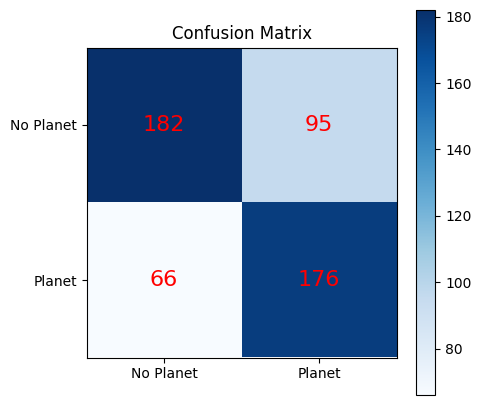

Model and scaler saved. Ready for inference!


In [ ]:
# -------------------------------
# IMPORTS
# -------------------------------
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import matplotlib.pyplot as plt

# -------------------------------
# PARAMETERS
# -------------------------------
LABEL_FILE = "/content/labels_existence.csv"
LIGHTCURVE_DIR = "/content/drive/MyDrive/Data"

# -------------------------------
# FEATURE EXTRACTION FUNCTION
# -------------------------------
def extract_features(lc_file):
    """
    Reads a lightcurve CSV and returns statistical features.
    """
    df = pd.read_csv(lc_file)

    flux = df['flux'].values
    flux_err = df['flux_err'].values

    features = {}
    features['flux_mean'] = np.mean(flux)
    features['flux_std'] = np.std(flux)
    features['flux_median'] = np.median(flux)
    features['flux_min'] = np.min(flux)
    features['flux_max'] = np.max(flux)
    features['flux_skew'] = pd.Series(flux).skew()
    features['flux_kurt'] = pd.Series(flux).kurt()

    # Estimate dip features (simple transit proxy)
    flux_diff = features['flux_mean'] - flux
    features['dip_max'] = np.max(flux_diff)
    features['dip_mean'] = np.mean(flux_diff)
    features['dip_std'] = np.std(flux_diff)

    return features

# -------------------------------
# LOAD DATA AND EXTRACT FEATURES
# -------------------------------
labels_df = pd.read_csv(LABEL_FILE)

feature_list = []
for idx, row in labels_df.iterrows():
    lc_file = row['lightcurve_file']
    if os.path.exists(lc_file):
        feats = extract_features(lc_file)
        feature_list.append(feats)
    else:
        print(f"File missing: {lc_file}")

X = pd.DataFrame(feature_list)
y = labels_df['target'].values

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# -------------------------------
# FEATURE SCALING
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# LIGHTGBM MODEL
# -------------------------------
model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

# Train with callbacks for early stopping & logging
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(period=10)
    ]
)

# -------------------------------
# EVALUATION
# -------------------------------
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]  # probability
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {roc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["No Planet","Planet"])
plt.yticks([0,1], ["No Planet","Planet"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j],ha='center',va='center',color='red',fontsize=16)
plt.show()

# -------------------------------
# SAVE MODEL AND SCALER
# -------------------------------
import joblib
joblib.dump(model, "lgb_exoplanet_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved. Ready for inference!")




In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load trained model
model = joblib.load("/content/lgb_exoplanet_model.pkl")  # or your Drive path
print("✅ Model loaded")


✅ Model loaded


In [ ]:
file_path = '/content/kepler_10797460_lightcurve.csv'
def extract_features_from_lightcurve(file_path):
    df = pd.read_csv(file_path)
    flux = df['flux'].values

    # Basic statistical features (same as training)
    features = {
        'mean_flux': np.mean(flux),
        'std_flux': np.std(flux),
        'min_flux': np.min(flux),
        'max_flux': np.max(flux),
        'median_flux': np.median(flux),
        'range_flux': np.max(flux) - np.min(flux),
        'q25_flux': np.percentile(flux, 25),
        'q75_flux': np.percentile(flux, 75),
        'skew_flux': pd.Series(flux).skew(),
        'kurt_flux': pd.Series(flux).kurt()
    }

    return np.array(list(features.values())).reshape(1, -1)


In [ ]:
# Path to new lightcurve CSV file
new_file = "/content/kepler_10797460_lightcurve.csv"

# Extract features
X_new = extract_features_from_lightcurve(new_file)

# Predict probability
prob = model.predict_proba(X_new)[0][1]  # Probability for class '1'
pred = model.predict(X_new)[0]           # 0 or 1 prediction

print(f"🪐 Exoplanet Existence Probability: {prob*100:.2f}%")
print(f"Predicted Class: {pred} (1 = Exoplanet, 0 = No Exoplanet)")


🪐 Exoplanet Existence Probability: 85.68%
Predicted Class: 1 (1 = Exoplanet, 0 = No Exoplanet)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# -------------------------------
# IMPORTS
# -------------------------------
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle  # For periodicity features
import joblib

# -------------------------------
# PARAMETERS
# -------------------------------
LABEL_FILE = "/content/drive/MyDrive/labels_existence.csv"
LIGHTCURVE_DIR = "/content/drive/MyDrive/Data"

# -------------------------------
# FEATURE EXTRACTION FUNCTION
# -------------------------------
def extract_features(lc_file):
    """
    Reads a lightcurve CSV and returns statistical + periodic + segment features.
    """
    df = pd.read_csv(lc_file)

    # Use correct column names
    time = df['time_bjd'].values
    flux = df['flux'].values
    flux_err = df['flux_err'].values

    features = {}

    # --- Basic statistics ---
    features['flux_mean'] = np.mean(flux)
    features['flux_std'] = np.std(flux)
    features['flux_median'] = np.median(flux)
    features['flux_min'] = np.min(flux)
    features['flux_max'] = np.max(flux)
    features['flux_skew'] = pd.Series(flux).skew()
    features['flux_kurt'] = pd.Series(flux).kurt()

    # --- Dip features (transit proxy) ---
    flux_diff = features['flux_mean'] - flux
    features['dip_max'] = np.max(flux_diff)
    features['dip_mean'] = np.mean(flux_diff)
    features['dip_std'] = np.std(flux_diff)

    # --- Periodicity features using Lomb–Scargle ---
    try:
        frequency, power = LombScargle(time, flux).autopower()
        best_freq = frequency[np.argmax(power)]
        features['best_period'] = 1 / best_freq if best_freq > 0 else 0
        features['period_power'] = np.max(power)
    except Exception:
        features['best_period'] = 0
        features['period_power'] = 0

    # --- Segment-based slope & variance ---
    n_segments = 5
    segment_len = len(flux) // n_segments if len(flux) >= n_segments else len(flux)
    slopes = []
    vars_ = []
    for i in range(n_segments):
        start = i * segment_len
        end = start + segment_len
        seg_time = time[start:end]
        seg_flux = flux[start:end]
        if len(seg_time) > 1:
            coeffs = np.polyfit(seg_time, seg_flux, 1)
            slopes.append(coeffs[0])
            vars_.append(np.var(seg_flux))
    features['slope_mean'] = np.mean(slopes) if slopes else 0
    features['slope_std'] = np.std(slopes) if slopes else 0
    features['var_mean'] = np.mean(vars_) if vars_ else 0
    features['var_std'] = np.std(vars_) if vars_ else 0

    return features

# -------------------------------
# LOAD DATA AND EXTRACT FEATURES
# -------------------------------
labels_df = pd.read_csv(LABEL_FILE)

feature_list = []
valid_targets = []
for idx, row in labels_df.iterrows():
    lc_file = row['lightcurve_file']
    if os.path.exists(lc_file):
        feats = extract_features(lc_file)
        feature_list.append(feats)
        valid_targets.append(row['target'])
    else:
        print(f"File missing: {lc_file}")

X = pd.DataFrame(feature_list)
y = np.array(valid_targets)

print("✅ Feature matrix shape:", X.shape)
print("✅ Target vector shape:", y.shape)

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# -------------------------------
# FEATURE SCALING
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# LIGHTGBM MODEL
# -------------------------------
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    random_state=42
)

# Train with callbacks for early stopping & logging
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=20)
    ]
)

# -------------------------------
# EVALUATION
# -------------------------------
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"\n🎯 Test Accuracy: {acc:.4f}")
print(f"🪐 ROC AUC Score: {roc:.4f}")
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["No Planet","Planet"])
plt.yticks([0,1], ["No Planet","Planet"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j],ha='center',va='center',color='red',fontsize=16)
plt.show()

# -------------------------------
# SAVE MODEL AND SCALER
# -------------------------------
joblib.dump(model, "/content/lgb_exoplanet_model.pkl")
joblib.dump(scaler, "/content/scaler.pkl")
print("✅ Model and scaler saved to /content/")


KeyboardInterrupt: 

In [ ]:
!pip install tensorflow scikit-learn astropy tqdm pandas numpy scipy

In [ ]:
import os, json, math
import numpy as np, pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from scipy.signal import savgol_filter
from scipy import stats
# Lomb-Scargle (optional, makes useful features)
from astropy.timeseries import LombScargle


In [ ]:
LABELS_CSV = "/content/drive/MyDrive/labels_features.csv"
DATA_DIR = "/content/drive/MyDrive/Data"
PROCESSED_DIR = "/content/drive/MyDrive/processed_lc"   # where we store preprocessed .npz
os.makedirs(PROCESSED_DIR, exist_ok=True)

TARGET_LENGTH = 2048       # resampled length (tune to GPU)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

TARGET_KEYS = [
 "koi_period","koi_depth","koi_prad","koi_teq","koi_steff","koi_srad",
 "koi_model_snr","pl_orbsmax","pl_rade","pl_masse","pl_dens","pl_eqt"
]


In [ ]:
def read_lc(path):
    # robust loader: try different separators
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, sep=None, engine='python')  # auto-detect
    # find columns by name heuristics
    cols = [c.lower() for c in df.columns]
    time_col = [c for c in df.columns if 'time' in c.lower()][0]
    flux_col = [c for c in df.columns if c.lower().startswith('flux') and 'err' not in c.lower()][0]
    # flux_err optional
    flux_err_candidates = [c for c in df.columns if 'err' in c.lower() or 'error' in c.lower()]
    flux_err_col = flux_err_candidates[0] if flux_err_candidates else None
    time = df[time_col].values.astype(float)
    flux = df[flux_col].values.astype(float)
    flux_err = df[flux_err_col].values.astype(float) if flux_err_col else None
    # sort
    order = np.argsort(time)
    return time[order], flux[order], (flux_err[order] if flux_err is not None else None)

def safe_savgol(y, window_frac=0.02, polyorder=3):
    n = len(y)
    w = max(5, int(n * window_frac))
    if w % 2 == 0: w += 1
    if w >= n:
        return np.median(y) * np.ones_like(y)
    try:
        return savgol_filter(y, w, polyorder)
    except Exception:
        return np.median(y) * np.ones_like(y)

def compute_tabular_features(time, flux):
    feats = {}
    # basic stats
    feats['mean'] = np.nanmean(flux)
    feats['std'] = np.nanstd(flux)
    feats['median'] = np.nanmedian(flux)
    feats['min'] = np.nanmin(flux)
    feats['max'] = np.nanmax(flux)
    feats['skew'] = float(stats.skew(flux, nan_policy='omit'))
    feats['kurtosis'] = float(stats.kurtosis(flux, nan_policy='omit'))
    for p in [1,5,25,50,75,95,99]:
        feats[f'p{p}'] = np.nanpercentile(flux, p)
    feats['mad'] = np.nanmedian(np.abs(flux - np.nanmedian(flux)))
    feats['rms'] = np.sqrt(np.nanmean(flux**2))
    # fraction of outliers (zscore > 5)
    z = np.abs(stats.zscore(flux, nan_policy='omit'))
    feats['frac_outliers'] = float(np.sum(z>5) / len(flux))

    # Lomb-Scargle period estimate (fast approximate)
    try:
        # restrict to physically plausible periods: 0.1 to 1000 days (adjust if needed)
        ls = LombScargle(time, flux)
        freq, power = ls.autopower(minimum_frequency=1/1000, maximum_frequency=1/0.1, samples_per_peak=2)
        best_idx = np.nanargmax(power)
        best_freq = freq[best_idx]
        feats['ls_period'] = float(1.0 / best_freq)
        feats['ls_power'] = float(power[best_idx])
    except Exception:
        feats['ls_period'] = np.nan
        feats['ls_power'] = np.nan
    return feats

def preprocess_and_save(path, out_path, target_length=TARGET_LENGTH):
    time, flux, ferr = read_lc(path)
    # drop NaNs
    mask = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[mask], flux[mask]
    if len(time) < 50:
        raise ValueError(f"too few points in {path}")
    # divide by median baseline
    flux = flux / np.nanmedian(flux)
    # detrend
    trend = safe_savgol(flux, window_frac=0.02, polyorder=3)
    flux_detrended = flux / np.maximum(trend, 1e-12) - 1.0   # relative flux
    # optional clip extreme outliers
    med = np.nanmedian(flux_detrended)
    mad = np.nanmedian(np.abs(flux_detrended - med))
    clip_low, clip_high = med - 10*mad, med + 10*mad
    flux_detrended = np.clip(flux_detrended, clip_low, clip_high)

    # uniform resample
    uni_time = np.linspace(time.min(), time.max(), target_length)
    uni_flux = np.interp(uni_time, time, flux_detrended)

    # standardize to zero mean, unit std (per light curve)
    uni_flux = (uni_flux - np.mean(uni_flux)) / (np.std(uni_flux) + 1e-12)

    # tabular features computed on detrended original (not resampled) for more fidelity
    tab_feats = compute_tabular_features(time, flux_detrended)

    # save
    np.savez_compressed(out_path, flux=uni_flux.astype(np.float32), **tab_feats)
    return out_path


In [ ]:
labels_df = pd.read_csv(LABELS_CSV)
# ensure path column name exactly matches; user said it's 'lightcurve_file'
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    lc_path = row['lightcurve_file']
    if not os.path.exists(lc_path):
        print("missing:", lc_path)
        continue
    fname = os.path.basename(lc_path).replace('.csv','.npz')
    out_path = os.path.join(PROCESSED_DIR, fname)
    if not os.path.exists(out_path):
        try:
            preprocess_and_save(lc_path, out_path, target_length=TARGET_LENGTH)
        except Exception as e:
            print("failed", lc_path, e)


100%|██████████| 4985/4985 [1:59:39<00:00,  1.44s/it]


In [ ]:
from glob import glob
import os
import numpy as np
from tqdm import tqdm

processed_files = sorted(glob(os.path.join(PROCESSED_DIR, "*.npz")))

X_ts = []
X_tab = []
Y = []
rows = []

tab_keys = ['mean','std','median','min','max','skew','kurtosis','mad','rms','frac_outliers','ls_period','ls_power']

for p in tqdm(processed_files):
    base_csv = os.path.basename(p).replace('.npz','.csv')

    # find matching label row
    match = labels_df[labels_df['lightcurve_file'].str.endswith(base_csv)]
    if match.empty:
        match = labels_df[labels_df['lightcurve_file'].str.contains(base_csv.replace('_lightcurve.csv',''))]
        if match.empty:
            continue

    row = match.iloc[0]

    arr = np.load(p)
    flux = arr['flux']  # shape (TARGET_LENGTH,)

    tab = [float(arr[k]) if k in arr else np.nan for k in tab_keys]

    X_ts.append(flux.reshape(-1,1))
    X_tab.append(tab)
    Y.append([row[k] for k in TARGET_KEYS])
    rows.append(row.name)

X_ts = np.array(X_ts, dtype=np.float32)
X_tab = np.array(X_tab, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print(X_ts.shape, X_tab.shape, Y.shape)


100%|██████████| 4315/4315 [03:12<00:00, 22.42it/s]

(4315, 2048, 1) (4315, 12) (4315, 12)


In [ ]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
import numpy as np

apply_log = {}
Y_proc = Y.copy()

for i, key in enumerate(TARGET_KEYS):
    arr = Y[:, i]

    if np.all(arr > 0):
        # Work on a copy to avoid overflow in skew
        arr_copy = np.copy(arr)

        # Clip extreme outliers just for skewness detection
        arr_copy = np.clip(arr_copy, np.percentile(arr_copy, 1), np.percentile(arr_copy, 99))

        try:
            skewness = stats.skew(arr_copy, nan_policy='omit')
        except Exception as e:
            print(f"Warning computing skew for {key}: {e}")
            skewness = 0

        apply_log[key] = (skewness > 1.0)
    else:
        apply_log[key] = False

# ✅ Apply log1p where needed
for i, key in enumerate(TARGET_KEYS):
    if apply_log[key]:
        Y_proc[:, i] = np.log1p(Y_proc[:, i])

# ✅ Scale targets
target_scaler = StandardScaler()
Y_scaled = target_scaler.fit_transform(Y_proc)

print("Transform applied to targets:", apply_log)


Transform applied to targets: {'koi_period': np.True_, 'koi_depth': np.True_, 'koi_prad': np.True_, 'koi_teq': np.True_, 'koi_steff': np.False_, 'koi_srad': np.True_, 'koi_model_snr': np.True_, 'pl_orbsmax': np.True_, 'pl_rade': np.True_, 'pl_masse': np.True_, 'pl_dens': np.True_, 'pl_eqt': np.True_}


In [ ]:
idx = np.arange(len(Y_scaled))
train_idx, test_idx = train_test_split(idx, test_size=0.30, random_state=RANDOM_SEED)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=RANDOM_SEED)

X_ts_train, X_ts_val, X_ts_test = X_ts[train_idx], X_ts[val_idx], X_ts[test_idx]
X_tab_train, X_tab_val, X_tab_test = X_tab[train_idx], X_tab[val_idx], X_tab[test_idx]
y_train, y_val, y_test = Y_scaled[train_idx], Y_scaled[val_idx], Y_scaled[test_idx]

print("train/val/test:", len(train_idx), len(val_idx), len(test_idx))


train/val/test: 3020 647 648


In [ ]:
def build_hybrid_model(input_length=TARGET_LENGTH, n_tab=X_tab.shape[1], n_out=len(TARGET_KEYS)):
    # time-series branch
    ts_in = Input(shape=(input_length,1), name='lc_input')
    x = layers.Conv1D(32, 11, padding='same', activation=None)(ts_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(4)(x)

    x = layers.Conv1D(64, 7, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(4)(x)

    x = layers.Conv1D(128, 5, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # tabular branch
    tab_in = Input(shape=(n_tab,), name='tab_input')
    t = layers.Dense(64, activation='relu')(tab_in)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(0.2)(t)

    # concatenate
    concat = layers.Concatenate()([x, t])
    h = layers.Dense(128, activation='relu')(concat)
    h = layers.Dropout(0.25)(h)
    h = layers.Dense(64, activation='relu')(h)

    out = layers.Dense(n_out, activation='linear', name='out')(h)

    model = Model(inputs=[ts_in, tab_in], outputs=out)
    # Huber loss is robust to outliers; use Adam optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

model = build_hybrid_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lc_input            │ (None, 2048, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2048, 32)  │        384 │ lc_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2048, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 32)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 512, 64)   │     14,400 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 128, 64)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 128)  │     41,088 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        832 │ tab_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat

 Total params: 108,108 (422.30 KB)

 Trainable params: 107,532 (420.05 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
batch_size = 32
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_model.h5', save_best_only=True, monitor='val_loss')
]

# simple data augmentation function
def augment_batch(Xb_ts, sigma=0.02):
    noise = np.random.normal(0, sigma, size=Xb_ts.shape)
    return Xb_ts + noise

# training loop with in-memory arrays
history = model.fit(
    x = [augment_batch(X_ts_train, sigma=0.01), X_tab_train],
    y = y_train,
    validation_data = ([X_ts_val, X_tab_val], y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = callbacks,
    shuffle=True
)


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.3666 - mae: 0.7182

95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - loss: 0.3662 - mae: 0.7177 - val_loss: 0.3461 - val_mae: 0.7076 - learning_rate: 0.0010
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.2779 - mae: 0.5956

95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - loss: 0.2779 - mae: 0.5956 - val_loss: 0.3186 - val_mae: 0.6662 - learning_rate: 0.0010
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2691 - mae: 0.5843

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - loss: 0.2691 - mae: 0.5843 - val_loss: 0.3044 - val_mae: 0.6382 - learning_rate: 0.0010
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2617 - mae: 0.5726

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - loss: 0.2617 - mae: 0.5727 - val_loss: 0.2959 - val_mae: 0.6327 - learning_rate: 0.0010
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 0.2586 - mae: 0.5674 - val_loss: 0.3202 - val_mae: 0.6690 - learning_rate: 0.0010
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - loss: 0.2539 - mae: 0.5599 - val_loss: 0.2989 - val_mae: 0.6374 - learning_rate: 0.0010
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2488 - mae: 0.5535

95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - loss: 0.2488 - mae: 0.5535 - val_loss: 0.2957 - val_mae: 0.6327 - learning_rate: 0.0010
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2487 - mae: 0.5523

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - loss: 0.2487 - mae: 0.5523 - val_loss: 0.2756 - val_mae: 0.5974 - learning_rate: 0.0010
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2451 - mae: 0.5470

95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - loss: 0.2452 - mae: 0.5471 - val_loss: 0.2728 - val_mae: 0.5912 - learning_rate: 0.0010
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2413 - mae: 0.5397

95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - loss: 0.2414 - mae: 0.5397 - val_loss: 0.2715 - val_mae: 0.5859 - learning_rate: 0.0010
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2392 - mae: 0.5384

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - loss: 0.2393 - mae: 0.5384 - val_loss: 0.2640 - val_mae: 0.5694 - learning_rate: 0.0010
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2385 - mae: 0.5380

95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - loss: 0.2385 - mae: 0.5380 - val_loss: 0.2559 - val_mae: 0.5586 - learning_rate: 0.0010
Epoch 13/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - loss: 0.2329 - mae: 0.5276 - val_loss: 0.2620 - val_mae: 0.5596 - learning_rate: 0.0010
Epoch 14/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 0.2331 - mae: 0.5301 - val_loss: 0.2625 - val_mae: 0.5720 - learning_rate: 0.0010
Epoch 15/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 0.2320 - mae: 0.5257 - val_loss: 0.2939 - val_mae: 0.6216 - learning_rate: 0.0010
Epoch 16/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 0.2315 - mae: 0.5254 - val_loss: 0.2723 - val_mae: 0.5848 - learning_rate: 0.0010
Epoch 17/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 0.2275 - mae: 0.5192 - val_loss: 0.2680 - val_mae: 0.5750 - learning_rate: 0.0010
Epoch 18/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 0.2257 - mae: 0.5157 - val_loss: 0.3122 - val_mae: 0.6565 - learning_rate: 0.001

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------
# Load model & make predictions
# ----------------------------
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.h5', compile=False)

# Predict scaled targets
y_pred_scaled = model.predict([X_ts_test, X_tab_test], batch_size=32)

# Inverse scale
y_pred_proc = target_scaler.inverse_transform(y_pred_scaled)
y_true_proc = target_scaler.inverse_transform(y_test)

# ----------------------------
# Invert log transforms properly
# ----------------------------
y_pred_final = y_pred_proc.copy()
y_true_final = y_true_proc.copy()

for i, key in enumerate(TARGET_KEYS):
    if apply_log.get(key, False):
        # Clip values before expm1 to avoid overflow (exp(>700) blows up)
        y_pred_final[:, i] = np.expm1(np.clip(y_pred_final[:, i], a_min=None, a_max=700))
        y_true_final[:, i] = np.expm1(np.clip(y_true_final[:, i], a_min=None, a_max=700))

# ----------------------------
# Compute metrics per feature
# ----------------------------
results = []
for i, key in enumerate(TARGET_KEYS):
    y_pred_i = y_pred_final[:, i]
    y_true_i = y_true_final[:, i]
    mae = mean_absolute_error(y_true_i, y_pred_i)
    rmse = np.sqrt(mean_squared_error(y_true_i, y_pred_i))
    r2 = r2_score(y_true_i, y_pred_i)
    results.append({
        "Feature": key,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# ----------------------------
# Display results in a table
# ----------------------------
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="R²", ascending=False).reset_index(drop=True)

print("\n📊 Model Evaluation Results:")
print(df_results.to_string(index=False))


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

📊 Model Evaluation Results:
      Feature          MAE         RMSE        R²
koi_model_snr 1.835538e+02 6.349469e+02  0.305351
    koi_depth 2.229066e+04 8.107854e+04  0.256726
    koi_steff 4.795311e+02 6.930482e+02  0.194255
      pl_dens 2.163015e+01 6.495804e+01  0.161820
       pl_eqt 4.968494e+02 7.552704e+02  0.109971
      koi_teq 4.985828e+02 7.588688e+02  0.101470
   pl_orbsmax 1.846218e-01 3.106520e-01  0.042208
      pl_rade 1.885620e+01 8.861204e+01  0.038803
     koi_prad 1.871526e+01 8.871819e+01  0.036498
     koi_srad 1.087653e+00 9.882924e+00 -0.004058
     pl_masse 1.118139e+09 1.591684e+10 -0.004956
   koi_period 5.606660e+01 1.316898e+02 -0.111359


In [9]:
!pip install tensorflow scikit-learn astropy tqdm pandas numpy scipy

import os, json, math
import numpy as np, pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from scipy.signal import savgol_filter
from scipy import stats
from astropy.timeseries import LombScargle

# =========================
# PATHS & CONFIG
# =========================
LABELS_CSV = "/content/drive/MyDrive/labels_features.csv"
DATA_DIR = "/content/drive/MyDrive/Data"
PROCESSED_DIR = "/content/drive/MyDrive/processed_lc"
os.makedirs(PROCESSED_DIR, exist_ok=True)

TARGET_LENGTH = 2048
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

TARGET_KEYS = [
 "koi_period","koi_depth","koi_prad","koi_teq","koi_steff","koi_srad",
 "koi_model_snr","pl_orbsmax","pl_rade","pl_masse","pl_dens","pl_eqt"
]

# =========================
# DATA LOADING HELPERS
# =========================
def read_lc(path):
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, sep=None, engine='python')
    time_col = [c for c in df.columns if 'time' in c.lower()][0]
    flux_col = [c for c in df.columns if c.lower().startswith('flux') and 'err' not in c.lower()][0]
    time = df[time_col].values.astype(float)
    flux = df[flux_col].values.astype(float)
    order = np.argsort(time)
    return time[order], flux[order]

def safe_savgol(y, window_frac=0.02, polyorder=3):
    n = len(y)
    w = max(5, int(n * window_frac))
    if w % 2 == 0: w += 1
    if w >= n: return np.median(y) * np.ones_like(y)
    try: return savgol_filter(y, w, polyorder)
    except: return np.median(y) * np.ones_like(y)

def compute_tabular_features(time, flux):
    feats = {}
    feats['mean'] = np.nanmean(flux)
    feats['std'] = np.nanstd(flux)
    feats['median'] = np.nanmedian(flux)
    feats['min'] = np.nanmin(flux)
    feats['max'] = np.nanmax(flux)
    feats['skew'] = float(stats.skew(flux, nan_policy='omit'))
    feats['kurtosis'] = float(stats.kurtosis(flux, nan_policy='omit'))
    for p in [1,5,25,50,75,95,99]:
        feats[f'p{p}'] = np.nanpercentile(flux, p)
    feats['mad'] = np.nanmedian(np.abs(flux - np.nanmedian(flux)))
    feats['rms'] = np.sqrt(np.nanmean(flux**2))
    z = np.abs(stats.zscore(flux, nan_policy='omit'))
    feats['frac_outliers'] = float(np.sum(z>5) / len(flux))
    try:
        ls = LombScargle(time, flux)
        freq, power = ls.autopower(minimum_frequency=1/1000, maximum_frequency=1/0.1)
        best_idx = np.nanargmax(power)
        feats['ls_period'] = float(1.0 / freq[best_idx])
        feats['ls_power'] = float(power[best_idx])
    except:
        feats['ls_period'] = np.nan
        feats['ls_power'] = np.nan
    return feats

def preprocess_and_save(path, out_path, target_length=TARGET_LENGTH):
    time, flux = read_lc(path)
    mask = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[mask], flux[mask]
    if len(time) < 50:
        raise ValueError("too few points")

    flux = flux / np.nanmedian(flux)
    trend = safe_savgol(flux)
    flux_detrended = flux / np.maximum(trend, 1e-12) - 1.0

    med = np.nanmedian(flux_detrended)
    mad = np.nanmedian(np.abs(flux_detrended - med))
    flux_detrended = np.clip(flux_detrended, med-10*mad, med+10*mad)

    uni_time = np.linspace(time.min(), time.max(), target_length)
    uni_flux = np.interp(uni_time, time, flux_detrended)
    uni_flux = (uni_flux - np.mean(uni_flux)) / (np.std(uni_flux)+1e-12)

    tab_feats = compute_tabular_features(time, flux_detrended)
    np.savez_compressed(out_path, flux=uni_flux.astype(np.float32), **tab_feats)
    return out_path

# =========================
# BUILD DATA ARRAYS
# =========================
labels_df = pd.read_csv(LABELS_CSV)
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    lc_path = row['lightcurve_file']
    if not os.path.exists(lc_path): continue
    out_path = os.path.join(PROCESSED_DIR, os.path.basename(lc_path).replace('.csv','.npz'))
    if not os.path.exists(out_path):
        try: preprocess_and_save(lc_path, out_path)
        except Exception as e: print("fail", lc_path, e)

processed_files = sorted(glob(os.path.join(PROCESSED_DIR, "*.npz")))
tab_keys = ['mean','std','median','min','max','skew','kurtosis','mad','rms','frac_outliers','ls_period','ls_power']

X_ts, X_tab, Y = [], [], []
for p in tqdm(processed_files):
    base = os.path.basename(p).replace('.npz','.csv')
    match = labels_df[labels_df['lightcurve_file'].str.endswith(base)]
    if match.empty: continue
    row = match.iloc[0]
    arr = np.load(p)
    X_ts.append(arr['flux'].reshape(-1,1))
    X_tab.append([arr.get(k, np.nan) for k in tab_keys])
    Y.append([row[k] for k in TARGET_KEYS])

X_ts = np.array(X_ts, dtype=np.float32)
X_tab = np.array(X_tab, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# =========================
# TARGET TRANSFORMS
# =========================
apply_log = {}
Y_proc = Y.copy()
for i, key in enumerate(TARGET_KEYS):
    arr = Y[:, i]
    if np.all(arr > 0):
        arr_clip = np.clip(arr, np.percentile(arr,1), np.percentile(arr,99))
        skewness = stats.skew(arr_clip, nan_policy='omit')
        apply_log[key] = (skewness > 1.0)
    else:
        apply_log[key] = False

for i, key in enumerate(TARGET_KEYS):
    if apply_log[key]:
        Y_proc[:, i] = np.log1p(Y_proc[:, i])

target_scaler = StandardScaler()
Y_scaled = target_scaler.fit_transform(Y_proc)


100%|██████████| 4315/4315 [02:17<00:00, 31.35it/s]


In [ ]:



train_idx, test_idx = train_test_split(np.arange(len(Y_scaled)), test_size=0.3, random_state=RANDOM_SEED)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=RANDOM_SEED)

X_ts_train, X_ts_val, X_ts_test = X_ts[train_idx], X_ts[val_idx], X_ts[test_idx]
X_tab_train, X_tab_val, X_tab_test = X_tab[train_idx], X_tab[val_idx], X_tab[test_idx]
y_train, y_val, y_test = Y_scaled[train_idx], Y_scaled[val_idx], Y_scaled[test_idx]

# =========================
# MODEL (CNN + BiLSTM + Tabular)
# =========================
def build_hybrid_model(input_length, n_tab, n_out):
    ts_in = Input(shape=(input_length,1))
    x = layers.Conv1D(64, 11, padding='same')(ts_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(4)(x)

    x = layers.Conv1D(128, 7, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(4)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    tab_in = Input(shape=(n_tab,))
    t = layers.Dense(64, activation='relu')(tab_in)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(0.2)(t)

    concat = layers.Concatenate()([x, t])
    h = layers.Dense(128, activation='relu')(concat)
    h = layers.Dropout(0.3)(h)
    out = layers.Dense(n_out, activation='linear')(h)

    model = Model([ts_in, tab_in], out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

model = build_hybrid_model(TARGET_LENGTH, X_tab.shape[1], len(TARGET_KEYS))
model.summary()

# =========================
# TRAINING
# =========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_model.h5', save_best_only=True, monitor='val_loss')
]

def augment_ts(x, sigma=0.01):
    return x + np.random.normal(0, sigma, size=x.shape)

history = model.fit(
    [augment_ts(X_ts_train), X_tab_train], y_train,
    validation_data=([X_ts_val, X_tab_val], y_val),
    epochs=150, batch_size=32, shuffle=True, callbacks=callbacks
)

# =========================
# EVALUATION
# =========================
best_model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.h5', compile=False)
y_pred_scaled = best_model.predict([X_ts_test, X_tab_test], batch_size=32)
y_pred_proc = target_scaler.inverse_transform(y_pred_scaled)
y_test_proc = target_scaler.inverse_transform(y_test)

y_pred_final, y_true_final = y_pred_proc.copy(), y_test_proc.copy()
for i, key in enumerate(TARGET_KEYS):
    if apply_log[key]:
        y_pred_final[:,i] = np.expm1(y_pred_final[:,i])
        y_true_final[:,i] = np.expm1(y_true_final[:,i])

print("\n📊 Model Evaluation Results:")
print(f"{'Feature':15s} {'MAE':>12s} {'RMSE':>12s} {'R²':>8s}")
for i, key in enumerate(TARGET_KEYS):
    mae = mean_absolute_error(y_true_final[:,i], y_pred_final[:,i])
    rmse = math.sqrt(mean_squared_error(y_true_final[:,i], y_pred_final[:,i]))
    r2 = r2_score(y_true_final[:,i], y_pred_final[:,i])
    print(f"{key:15s} {mae:12.4g} {rmse:12.4g} {r2:8.4f}")

In [11]:
# Make sure these are defined first (same as in your training script)
TARGET_KEYS = [
 "koi_period","koi_depth","koi_prad","koi_teq","koi_steff","koi_srad",
 "koi_model_snr","pl_orbsmax","pl_rade","pl_masse","pl_dens","pl_eqt"
]
TARGET_LENGTH = 2048   # or whatever you used during training

def infer_single_csv(csv_path, model, target_scaler, apply_log_map,
                     target_keys=TARGET_KEYS, target_length=TARGET_LENGTH):
    # Read and preprocess the light curve
    time, flux = read_lc(csv_path)  # <-- only 2 values now
    flux = flux / np.nanmedian(flux)
    trend = safe_savgol(flux, window_frac=0.02, polyorder=3)
    flux_d = flux / np.maximum(trend,1e-12) - 1.0

    # Resample to fixed length
    uni_time = np.linspace(time.min(), time.max(), target_length)
    uni_flux = np.interp(uni_time, time, flux_d)
    uni_flux = (uni_flux - np.mean(uni_flux)) / (np.std(uni_flux) + 1e-12)

    # Compute tabular features
    tab = compute_tabular_features(time, flux_d)
    tab_keys = ['mean','std','median','min','max','skew','kurtosis','mad',
                'rms','frac_outliers','ls_period','ls_power']
    tab_arr = np.array([tab.get(k, np.nan) for k in tab_keys], dtype=np.float32).reshape(1,-1)

    # Make prediction
    pred_scaled = model.predict([uni_flux.reshape(1,-1,1), tab_arr])
    pred_proc = target_scaler.inverse_transform(pred_scaled)

    # Invert log transform where applied
    out = {}
    for i, key in enumerate(target_keys):
        val = pred_proc[0, i]
        if apply_log_map.get(key, False):
            val = np.expm1(val)
        out[key] = float(val)

    return json.dumps(out, indent=2)



In [12]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.h5', compile=False)
result_json = infer_single_csv(
    "/content/drive/MyDrive/Data/kepler_1025986_lightcurve.csv",
    model,
    target_scaler,
    apply_log
)
print(result_json)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{
  "koi_period": 11.039068222045898,
  "koi_depth": 416.8121032714844,
  "koi_prad": 2.961278200149536,
  "koi_teq": 779.3360595703125,
  "koi_steff": 5516.38671875,
  "koi_srad": 0.9790551066398621,
  "koi_model_snr": 25.72298812866211,
  "pl_orbsmax": 0.1513693928718567,
  "pl_rade": 2.945708751678467,
  "pl_masse": 44.26495361328125,
  "pl_dens": 10.811491012573242,
  "pl_eqt": 794.79248046875
}
